In [3]:
%cd 'C:\Users\hdagne1\Box\Dr.Mesfin Research\Summer_Institute_clones\HydroLSTM'

[WinError 123] The filename, directory name, or volume label syntax is incorrect: "'C:\\Users\\hdagne1\\Box\\Dr.Mesfin Research\\Summer_Institute_clones\\HydroLSTM'"
c:\Users\hdagne1\Box\Dr.Mesfin Research\Summer_Institute_clones\HydroLSTM


In [4]:
pwd

'c:\\Users\\hdagne1\\Box\\Dr.Mesfin Research\\Summer_Institute_clones\\HydroLSTM'

In [5]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return pd.DataFrame(agg.astype('float32'))

In [7]:
def train_valid_test_split(data, hours_of_history, hours_to_predict, parameters_included):
  data_train_valid = data.iloc[:52608,:] # the first 6 years for training/validation
  data_test = data.iloc[52608:,:] # the last 1 years for test evaluation
  data_train_valid.dropna(inplace=True)
  data_test.dropna(inplace=True)

  data_valid, data_train = train_test_split(data_train_valid, test_size=0.4, shuffle= False) # the last 60% data in the first 6 years used for training and the first 40% used for validation.

  return data_train.values, data_valid.values, data_test.values

In [8]:
def prepare_data(station_id, hours_of_history, hours_to_predict, parameters_included):

  data = pd.read_csv('./data/'+str(station_id)+'_data.csv').iloc[:,1:]

  # simple min-max scaling. Other pretreatments such as normalization also work.
  scaler = MinMaxScaler()
  scaler.fit(data.iloc[:52608,:]) # min-max scaling without the test dataset.
  q_max = np.max(data.iloc[:52608,2]) # manually check the maximum and minimum discharge
  q_min = np.min(data.iloc[:52608,2])
  data_scaled = scaler.transform(data)

  # data split
  data_sequence = series_to_supervised(data_scaled, hours_of_history, hours_to_predict)
  data_train, data_valid, data_test = train_valid_test_split(data_sequence, hours_of_history, hours_to_predict, parameters_included)

  # Split data into 2 parts for encoder (history) and decoder(future).
  train_x_rainfall = data_train[:,0::3].reshape(-1, hours_of_history+hours_to_predict, 1)
  train_discharge = data_train[:,2::3].reshape(-1, hours_of_history+hours_to_predict, 1)
  train_x_discharge = train_discharge[:,:hours_of_history,:]
  train_y = train_discharge[:,hours_of_history:,:]
  train_x_et = data_train[:,3*hours_of_history+1].reshape(-1, 1) # the current hour et

  valid_x_rainfall = data_valid[:,0::3].reshape(-1, hours_of_history+hours_to_predict, 1)
  valid_discharge = data_valid[:,2::3].reshape(-1, hours_of_history+hours_to_predict, 1)
  valid_x_discharge = valid_discharge[:,:hours_of_history,:]
  valid_y = valid_discharge[:,hours_of_history:,:]
  valid_x_et = data_valid[:,3*hours_of_history+1].reshape(-1, 1) # the current hour et

  test_x_rainfall = data_test[:,0::3].reshape(-1, hours_of_history+hours_to_predict, 1)
  test_discharge = data_test[:,2::3].reshape(-1, hours_of_history+hours_to_predict, 1)
  test_x_discharge = test_discharge[:,:hours_of_history,:]
  test_y = test_discharge[:,hours_of_history:,:]
  test_x_et = data_test[:,3*hours_of_history+1].reshape(-1, 1) # the current hour et

  return [train_x_et, train_x_discharge, train_x_rainfall], train_y, [valid_x_et, valid_x_discharge, valid_x_rainfall], valid_y, [test_x_et, test_x_discharge, test_x_rainfall], test_y, q_max, q_min

In [9]:
# define custome loss function (you can use the simple 'mse' as well)
def nseloss(y_true, y_pred):
  return K.sum((y_pred-y_true)**2)/K.sum((y_true-K.mean(y_true))**2)

In [10]:
def EDLSTM(hours_of_history, hours_to_predict, parameters_included):

  # design network
  # input of runoff observation, LSTM encoder
  input_1 = Input(shape=(hours_of_history, 1), name='LSTM1_input') # shape should be 72*1 for runoff observation
  LSTM1 = LSTM(256, return_sequences=False)(input_1)

  # input of rainfall observation and forecast, LSTM encoder
  input_2 = Input(shape=((hours_of_history+hours_to_predict), 1), name='LSTM2_input') # shape should be (72+24)*n=96*n, for rainfall observation (72) and predictions (24) for rainfall and additional stations (if there is no upstream station, n=1)
  LSTM2 = LSTM(256, return_sequences=False)(input_2)

  # input of other non-timeseries data, such as daily or monthly data.
  input_phys = Input(shape=(1,), name='phys_input') # one single value of ET. shape = 1.

  # connect all data
  x = concatenate([input_phys, LSTM1, LSTM2]) # Get state vector.
  x = RepeatVector(hours_to_predict)(x) # 24 is the output time dimension

  # LSTM decoder
  x = LSTM(512, return_sequences=True)(x)

  # define fully-connected dense layers
  dim_dense=[512, 256, 256, 128, 64]

  # final fully-connected dense layer for final result
  for dim in dim_dense:
    x = TimeDistributed(Dense(dim, activation='relu'))(x)
    x = TimeDistributed(Dropout(0.2))(x) # Some dropout for dense layers. Some paper mentioned that it is not recommend to have dropout between the RNN/LSTM/GRU layers. Thus, I only apply dropout in the dense layer.
  main_out = TimeDistributed(Dense(1, activation='relu'))(x) # here relu provides the final output non-negative, which is corrosponding to my min-max pre-prossing.
  main_out = Flatten()(main_out)

  model = Model(inputs=[input_phys, input_1, input_2], outputs=main_out)
  
  return model

In [11]:
# identify KGE, NSE for evaluation
def nse(y_true, y_pred):
  return 1-np.sum((y_pred-y_true)**2)/np.sum((y_true-np.mean(y_true))**2)
  
def kge(y_true, y_pred):
  kge_r = np.corrcoef(y_true,y_pred)[1][0]
  kge_a = np.std(y_pred)/np.std(y_true)
  kge_b = np.mean(y_pred)/np.mean(y_true)
  return 1-np.sqrt((kge_r-1)**2+(kge_a-1)**2+(kge_b-1)**2)


In [ ]:
def main():
  
  # parameters
  station_id = 521
  hours_to_predict = 24
  hours_of_history = 72
  parameters_included = 3

  batch_size = 64
  lr = 0.0001
  epochs = 300
  test_name = './'+str(station_id)+'_model1_'

  # load data
  x_train, y_train, x_valid, y_valid, x_test, y_test, q_max, q_min = prepare_data(station_id, hours_of_history, hours_to_predict, parameters_included)
  model1 = EDLSTM(hours_of_history, hours_to_predict, parameters_included)

  # compile settings
  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=15, cooldown=30, min_lr=1e-8)
  earlystoping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')
  checkpoint = ModelCheckpoint(test_name+'model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
  optimizer = RMSprop(learning_rate=lr)  # optimizer = RMSprop(lr=lr)
  
  model1.compile(optimizer=optimizer, loss=nseloss) # I used the build-in RMSprop, loss function is 1-NSE. You can use 'mse', 'mae' as well.

  # train model
  history = model1.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
              validation_data=(x_valid, y_valid), callbacks=[reduce_lr, earlystoping, checkpoint], verbose=1)

  # save training loss
  loss_train = history.history['loss']
  loss_valid = history.history['val_loss']
  loss_train = pd.DataFrame({'TrainLoss':loss_train})
  loss_valid = pd.DataFrame({'TestLoss':loss_valid})
  LossEpoches = pd.concat([loss_train, loss_valid], axis=1)
  LossEpoches.to_csv(test_name+'loss.csv', index = True)

  # Final Test Review
  model1.load_weights(test_name+'model.h5')

  y_model_scaled = model1.predict(x_test)
  y_model = y_model_scaled*(q_max-q_min)+q_min
  y_test = y_test*(q_max-q_min)+q_min

  # hourly evaluation
  NSEs=[]
  KGEs=[]
  for x in range(0, 24):
    y_pred = y_model[:,x]
    y_True = y_test[:,x]
    NSEs.append(nse(y_True[:,0],y_pred))
    KGEs.append(kge(y_True[:,0],y_pred))  
    
  NSEs=pd.DataFrame(NSEs)
  NSEs.columns = ['NSE_Test']
  KGEs=pd.DataFrame(KGEs)
  KGEs.columns = ['KGE_Test']
    
  eva = pd.concat([NSEs, KGEs], axis=1)
  eva.to_csv(test_name+'eva.csv', index = True)
 

In [ ]:
if __name__ == "__main__":
  main()


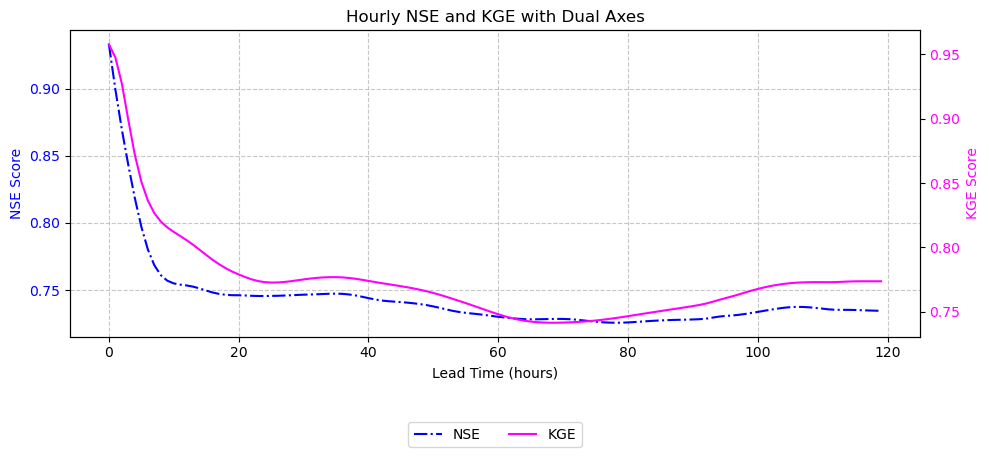

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load evaluation data
eva_df = pd.read_csv('521_model2_eva.csv')

# Create figure and axis objects with a single subplot
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot NSE on the first y-axis
ax1.plot(eva_df['NSE_Test'], color='blue', linestyle='-.', label='NSE')
ax1.set_xlabel('Lead Time (hours)')
ax1.set_ylabel('NSE Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, linestyle='--', alpha=0.7)

# Create a second y-axis for KGE
ax2 = ax1.twinx()
ax2.plot(eva_df['KGE_Test'], color='magenta', linestyle='-', label='KGE')
ax2.set_ylabel('KGE Score', color='magenta')
ax2.tick_params(axis='y', labelcolor='magenta')

# Add title and legend
plt.title('Hourly NSE and KGE with Dual Axes')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2, bbox_transform=fig.transFigure)
plt.tight_layout()

# Save the plot
# plt.savefig('dual_axis_nse_kge.png')
plt.show()